### Let's plot our most recent Torque log in python

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import osmapping

In [5]:
fname2 = '/Users/astyler/Desktop/torqueTrackLog.csv'
df = pd.read_csv(fname2, na_values=['-'], index_col=False, header=False,names=['GPSTime','Time','Longitude','Latitude','GPSSpeed','GPSError','Altitude','Bearing','Gx','Gy','Gz','G'])
df = df.dropna(subset = ['Longitude','Latitude'])
df.head()

,GPSTime,Time,Longitude,Latitude,GPSSpeed,GPSError,Altitude,Bearing,Gx,Gy,Gz,G
285,Mon Jun 22 18:02:57 EDT 2015,22-Jun-2015 18:02:10.764,-71.092698,42.365715,0.662574,15,26.376932,240.81718,4.568137,-6.952762,1.235408,-0.123670
286,Mon Jun 22 18:02:57 EDT 2015,22-Jun-2015 18:02:11.265,-71.092698,42.365715,0.662574,15,26.376932,240.81718,5.726931,-6.655881,0.919373,-0.081043
287,Mon Jun 22 18:02:58 EDT 2015,22-Jun-2015 18:02:11.764,-71.092704,42.365760,1.000519,25,22.678742,246.36047,10.975020,-8.896853,3.782839,0.509910
288,Mon Jun 22 18:02:58 EDT 2015,22-Jun-2015 18:02:12.264,-71.092704,42.365760,1.000519,25,22.678742,246.36047,7.594408,-5.659893,4.520253,0.088812
289,Mon Jun 22 18:02:59 EDT 2015,22-Jun-2015 18:02:12.764,-71.092730,42.365793,0.570067,10,29.586119,180.74815,6.502652,-4.673482,4.223372,-0.058133


In [6]:
%matplotlib inline
ll = (min(df.Longitude),min(df.Latitude))
ur = (max(df.Longitude),max(df.Latitude))
mymap = osmapping.MLMap(ll,ur)

df['x'],df['y'] = mymap.convert_coordinates(df[['Longitude','Latitude']].values).T

In [7]:
mymap.load_shape_file('./shapefiles/boston/line.shp')

In [8]:
mymap.load_shape_file('./shapefiles/boston/polygon.shp')

In [48]:
road = {'edgecolor':'#93a1a1','lw':3, 'facecolor':'none','zorder':5};
mymap.clear_selected_shapes()
mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#859900',edgecolor='none',zorder=4)

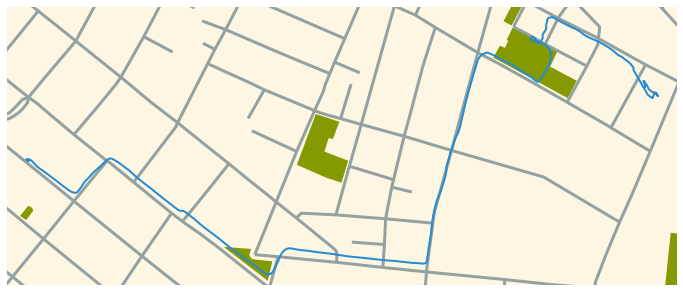

In [54]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax,fill='#fdf6e3')

#ax.plot(df.x,df.y,color='#268bd2',lw=2,zorder=6);

In [ ]:
#es solarized color reference
#base03:    #002b36;
#base02:    #073642;
#base01:    #586e75;
#base00:    #657b83;
#base0:     #839496;
#base1:     #93a1a1;
#base2:     #eee8d5;
#base3:     #fdf6e3;
#yellow:    #b58900;
#orange:    #cb4b16;
#red:       #dc322f;
#magenta:   #d33682;
#violet:    #6c71c4;
#blue:      #268bd2;
#cyan:      #2aa198;
#green:     #859900;